# 固定亂數確保每次執行結果相同

In [1]:
import torch 
import numpy as np 
import random 

def same_seeds(seed):
    random.seed(seed) 
    np.random.seed(seed)  
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
same_seeds(2526)

In [ ]:
import os, cv2
from tqdm import tqdm

def load_images_and_labels(root='Image'):
    encode, decode = {}, {}
    x_train, y_train, x_valid, y_valid = [], [], [], []

    for idx, cls in enumerate(os.listdir(f'{root}/Train')):
        encode[cls] = idx
        decode[idx] = cls                  # 雙向對照表

    for split in ['Train', 'Valid']:
        for cls in os.listdir(f'{root}/{split}'):
            path = f'{root}/{split}/{cls}'
            for fname in tqdm(os.listdir(path), desc=f'Loading {split}/{cls}'):
                img = cv2.imread(f'{path}/{fname}').astype("float32")
                if img is None:  # 避免讀檔失敗
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  / 255
                (x_train if split == 'Train' else x_valid).append(img)
                (y_train if split == 'Train' else y_valid).append(encode[cls])
    return x_train, y_train, x_valid, y_valid, encode, decode


x_train, y_train, x_valid, y_valid, label_encoding, label_decoding = load_images_and_labels('Image')

Loading Valid/Truck: 100%|██████████| 1000/1000 [00:00<00:00, 4082.04it/s]


x_train shape: (50000, 32, 32)


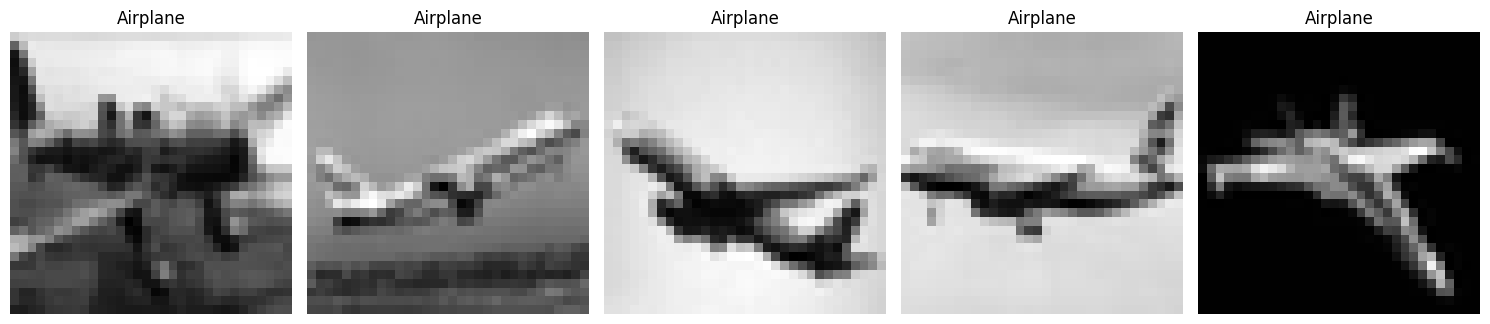

In [3]:
import matplotlib.pyplot as plt

def show_images(images, labels, label_decoding, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(min(num_images, len(images))):  # 顯示指定數量的圖片
        img = images[i]
        label = labels[i]
        class_name = label_decoding[label]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')  # 指定灰階顯示
        plt.title(class_name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print('x_train shape:', np.array(x_train).shape)
show_images(x_train, y_train, label_decoding, num_images=5)

# 亂數模擬資料

In [4]:
from torch.utils.data import Dataset, DataLoader

class CIFAR10(Dataset):
    def __init__(self, x, y):  
        self.x = x
        self.y = y
    def __len__(self):         
        return len(self.x)
    def __getitem__(self, i):  
        return self.x[i], self.y[i]

def collate_fn(batch):
    imgs, labels = [], []
    for img, lab in batch:
        img = torch.from_numpy(img)
        if random.random() < 0.5:               # 50% 機率水平翻轉
            img = torch.flip(img, dims=[1])
        imgs.append(img)
        labels.append(lab)
    return {'x': torch.stack(imgs), 'y': torch.tensor(labels)}


trainset = CIFAR10(x_train, y_train)
validset = CIFAR10(x_valid, y_valid)

train_loader = DataLoader(trainset, batch_size = 64, shuffle = True, num_workers = 0, pin_memory = True, collate_fn = collate_fn)
valid_loader = DataLoader(validset, batch_size = 64, shuffle = True, num_workers = 0, pin_memory = True, collate_fn = collate_fn)

batch = next(iter(train_loader))
print('train batch shape:', batch['x'].shape)

train batch shape: torch.Size([64, 32, 32])


In [5]:
import torch.nn as nn

class DNN(nn.Module):
    def __init__(self, hidden_layers=5, input_dim=32*32,
                 hidden_dim=1024, output_dim=10, dropout=0.5):
        super().__init__()
        layers = []
        for _ in range(hidden_layers):
            layers += [nn.Linear(input_dim, hidden_dim),
                       nn.BatchNorm1d(hidden_dim),
                       nn.ReLU(), nn.Dropout(dropout)]
            input_dim, hidden_dim = hidden_dim, max(hidden_dim // 2, 128)
        layers.append(nn.Linear(input_dim, output_dim))
        self.layers = nn.Sequential(*layers)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, **kwargs):
        x = kwargs['x']
        x = x.view(x.size(0), -1)   # Flatten: (B,32,32) → (B,1024)
        logits = self.layers(x)
        loss = self.criterion(logits, kwargs['y'])
        return loss, logits

    @torch.no_grad()
    def predict(self, **kwargs):
        self.eval()
        x = kwargs['x']
        x = x.view(x.size(0), -1)
        return torch.argmax(self.layers(x), dim=1).cpu().numpy()

model = DNN(
    hidden_layers = 5, 
    input_dim = 32*32, 
    hidden_dim = 1024, 
    output_dim = 10, 
    dropout = 0.5
)


Using device: cuda


Valid Epoch 0: 100%|██████████| 157/157 [00:00<00:00, 296.15it/s, loss=2.047]


Saving Model With Loss 1.87854
Train Loss: 2.09205| Valid Loss: 1.87854| Best Loss: 1.87854



Valid Epoch 1: 100%|██████████| 157/157 [00:00<00:00, 283.81it/s, loss=1.941]


Saving Model With Loss 1.83129
Train Loss: 1.93941| Valid Loss: 1.83129| Best Loss: 1.83129



Valid Epoch 2: 100%|██████████| 157/157 [00:00<00:00, 266.14it/s, loss=1.620]


Saving Model With Loss 1.76044
Train Loss: 1.88173| Valid Loss: 1.76044| Best Loss: 1.76044



Valid Epoch 3: 100%|██████████| 157/157 [00:00<00:00, 228.70it/s, loss=1.873]


Saving Model With Loss 1.74128
Train Loss: 1.84147| Valid Loss: 1.74128| Best Loss: 1.74128



Valid Epoch 4: 100%|██████████| 157/157 [00:00<00:00, 244.98it/s, loss=1.261]


Saving Model With Loss 1.70156
Train Loss: 1.81245| Valid Loss: 1.70156| Best Loss: 1.70156



Valid Epoch 5: 100%|██████████| 157/157 [00:00<00:00, 252.06it/s, loss=1.477]


Saving Model With Loss 1.67448
Train Loss: 1.78402| Valid Loss: 1.67448| Best Loss: 1.67448



Valid Epoch 6: 100%|██████████| 157/157 [00:00<00:00, 252.57it/s, loss=1.738]


Saving Model With Loss 1.63777
Train Loss: 1.76524| Valid Loss: 1.63777| Best Loss: 1.63777



Valid Epoch 7: 100%|██████████| 157/157 [00:00<00:00, 265.59it/s, loss=1.285]


Saving Model With Loss 1.62475
Train Loss: 1.74233| Valid Loss: 1.62475| Best Loss: 1.62475



Valid Epoch 8: 100%|██████████| 157/157 [00:00<00:00, 248.61it/s, loss=1.893]


Saving Model With Loss 1.61278
Train Loss: 1.73067| Valid Loss: 1.61278| Best Loss: 1.61278



Valid Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 267.48it/s, loss=1.565]


Train Loss: 1.71428| Valid Loss: 1.65525| Best Loss: 1.61278



Valid Epoch 10: 100%|██████████| 157/157 [00:00<00:00, 263.02it/s, loss=1.630]


Saving Model With Loss 1.58655
Train Loss: 1.69843| Valid Loss: 1.58655| Best Loss: 1.58655



Valid Epoch 11: 100%|██████████| 157/157 [00:00<00:00, 257.31it/s, loss=1.717]


Saving Model With Loss 1.56829
Train Loss: 1.68730| Valid Loss: 1.56829| Best Loss: 1.56829



Valid Epoch 12: 100%|██████████| 157/157 [00:00<00:00, 231.06it/s, loss=1.900]


Saving Model With Loss 1.56313
Train Loss: 1.67422| Valid Loss: 1.56313| Best Loss: 1.56313



Valid Epoch 13: 100%|██████████| 157/157 [00:00<00:00, 261.13it/s, loss=1.456]


Saving Model With Loss 1.55117
Train Loss: 1.66498| Valid Loss: 1.55117| Best Loss: 1.55117



Valid Epoch 14: 100%|██████████| 157/157 [00:00<00:00, 256.39it/s, loss=1.802]


Train Loss: 1.65165| Valid Loss: 1.56408| Best Loss: 1.55117



Valid Epoch 15: 100%|██████████| 157/157 [00:00<00:00, 245.37it/s, loss=1.367]


Saving Model With Loss 1.54024
Train Loss: 1.64530| Valid Loss: 1.54024| Best Loss: 1.54024



Valid Epoch 16: 100%|██████████| 157/157 [00:00<00:00, 241.44it/s, loss=1.432]


Saving Model With Loss 1.53756
Train Loss: 1.63685| Valid Loss: 1.53756| Best Loss: 1.53756



Valid Epoch 17: 100%|██████████| 157/157 [00:00<00:00, 246.85it/s, loss=1.457]


Saving Model With Loss 1.53054
Train Loss: 1.62464| Valid Loss: 1.53054| Best Loss: 1.53054



Valid Epoch 18: 100%|██████████| 157/157 [00:00<00:00, 249.58it/s, loss=1.526]


Saving Model With Loss 1.50726
Train Loss: 1.62080| Valid Loss: 1.50726| Best Loss: 1.50726



Valid Epoch 19: 100%|██████████| 157/157 [00:00<00:00, 249.84it/s, loss=1.498]


Train Loss: 1.60745| Valid Loss: 1.51135| Best Loss: 1.50726



Valid Epoch 20: 100%|██████████| 157/157 [00:00<00:00, 230.86it/s, loss=1.099]


Train Loss: 1.60130| Valid Loss: 1.50828| Best Loss: 1.50726



Valid Epoch 21: 100%|██████████| 157/157 [00:00<00:00, 231.23it/s, loss=1.724]


Saving Model With Loss 1.50490
Train Loss: 1.59266| Valid Loss: 1.50490| Best Loss: 1.50490



Valid Epoch 22: 100%|██████████| 157/157 [00:00<00:00, 252.66it/s, loss=1.988]


Saving Model With Loss 1.49802
Train Loss: 1.58873| Valid Loss: 1.49802| Best Loss: 1.49802



Valid Epoch 23: 100%|██████████| 157/157 [00:00<00:00, 241.86it/s, loss=1.467]


Saving Model With Loss 1.48692
Train Loss: 1.57981| Valid Loss: 1.48692| Best Loss: 1.48692



Valid Epoch 24: 100%|██████████| 157/157 [00:00<00:00, 214.58it/s, loss=1.857]


Train Loss: 1.57766| Valid Loss: 1.49254| Best Loss: 1.48692



Valid Epoch 25: 100%|██████████| 157/157 [00:00<00:00, 223.28it/s, loss=1.529]


Saving Model With Loss 1.47699
Train Loss: 1.56548| Valid Loss: 1.47699| Best Loss: 1.47699



Valid Epoch 26: 100%|██████████| 157/157 [00:00<00:00, 252.66it/s, loss=1.553]


Train Loss: 1.55908| Valid Loss: 1.48265| Best Loss: 1.47699



Valid Epoch 27: 100%|██████████| 157/157 [00:00<00:00, 229.74it/s, loss=1.470]


Saving Model With Loss 1.45790
Train Loss: 1.55260| Valid Loss: 1.45790| Best Loss: 1.45790



Valid Epoch 28: 100%|██████████| 157/157 [00:00<00:00, 221.89it/s, loss=0.974]


Train Loss: 1.54304| Valid Loss: 1.46010| Best Loss: 1.45790



Valid Epoch 29: 100%|██████████| 157/157 [00:00<00:00, 218.33it/s, loss=1.200]


Train Loss: 1.54360| Valid Loss: 1.46646| Best Loss: 1.45790



Valid Epoch 30: 100%|██████████| 157/157 [00:00<00:00, 240.70it/s, loss=1.599]


Train Loss: 1.53388| Valid Loss: 1.48769| Best Loss: 1.45790



Valid Epoch 31: 100%|██████████| 157/157 [00:00<00:00, 246.75it/s, loss=1.257]


Saving Model With Loss 1.45086
Train Loss: 1.52951| Valid Loss: 1.45086| Best Loss: 1.45086



Valid Epoch 32: 100%|██████████| 157/157 [00:00<00:00, 245.20it/s, loss=1.700]


Train Loss: 1.52594| Valid Loss: 1.45844| Best Loss: 1.45086



Valid Epoch 33: 100%|██████████| 157/157 [00:00<00:00, 238.75it/s, loss=1.025]


Saving Model With Loss 1.43671
Train Loss: 1.52278| Valid Loss: 1.43671| Best Loss: 1.43671



Valid Epoch 34: 100%|██████████| 157/157 [00:00<00:00, 258.63it/s, loss=1.775]


Train Loss: 1.51761| Valid Loss: 1.46640| Best Loss: 1.43671



Valid Epoch 35: 100%|██████████| 157/157 [00:00<00:00, 266.62it/s, loss=1.464]


Train Loss: 1.50923| Valid Loss: 1.43729| Best Loss: 1.43671



Valid Epoch 36: 100%|██████████| 157/157 [00:00<00:00, 241.76it/s, loss=1.703]


Train Loss: 1.50356| Valid Loss: 1.45125| Best Loss: 1.43671



Valid Epoch 37: 100%|██████████| 157/157 [00:00<00:00, 268.70it/s, loss=1.521]


Saving Model With Loss 1.43091
Train Loss: 1.49885| Valid Loss: 1.43091| Best Loss: 1.43091



Valid Epoch 38: 100%|██████████| 157/157 [00:00<00:00, 234.29it/s, loss=1.759]


Train Loss: 1.50037| Valid Loss: 1.44096| Best Loss: 1.43091



Valid Epoch 39: 100%|██████████| 157/157 [00:00<00:00, 228.45it/s, loss=1.576]


Saving Model With Loss 1.42147
Train Loss: 1.48953| Valid Loss: 1.42147| Best Loss: 1.42147



Valid Epoch 40: 100%|██████████| 157/157 [00:00<00:00, 272.71it/s, loss=1.395]


Train Loss: 1.48542| Valid Loss: 1.42367| Best Loss: 1.42147



Valid Epoch 41: 100%|██████████| 157/157 [00:00<00:00, 209.85it/s, loss=1.650]


Saving Model With Loss 1.41676
Train Loss: 1.48038| Valid Loss: 1.41676| Best Loss: 1.41676



Valid Epoch 42: 100%|██████████| 157/157 [00:00<00:00, 237.60it/s, loss=1.637]


Train Loss: 1.48080| Valid Loss: 1.43131| Best Loss: 1.41676



Valid Epoch 43: 100%|██████████| 157/157 [00:00<00:00, 236.96it/s, loss=1.263]


Saving Model With Loss 1.41219
Train Loss: 1.47487| Valid Loss: 1.41219| Best Loss: 1.41219



Valid Epoch 44: 100%|██████████| 157/157 [00:00<00:00, 239.51it/s, loss=1.102]


Train Loss: 1.46906| Valid Loss: 1.41282| Best Loss: 1.41219



Valid Epoch 45: 100%|██████████| 157/157 [00:00<00:00, 253.09it/s, loss=1.250]


Train Loss: 1.46525| Valid Loss: 1.41248| Best Loss: 1.41219



Valid Epoch 46: 100%|██████████| 157/157 [00:00<00:00, 207.71it/s, loss=1.103]


Train Loss: 1.45974| Valid Loss: 1.42266| Best Loss: 1.41219



Valid Epoch 47: 100%|██████████| 157/157 [00:00<00:00, 234.73it/s, loss=1.306]


Saving Model With Loss 1.40812
Train Loss: 1.45388| Valid Loss: 1.40812| Best Loss: 1.40812



Valid Epoch 48: 100%|██████████| 157/157 [00:00<00:00, 230.90it/s, loss=1.334]


Saving Model With Loss 1.40478
Train Loss: 1.44991| Valid Loss: 1.40478| Best Loss: 1.40478



Valid Epoch 49: 100%|██████████| 157/157 [00:00<00:00, 234.28it/s, loss=1.240]


Saving Model With Loss 1.40259
Train Loss: 1.45242| Valid Loss: 1.40259| Best Loss: 1.40259



Valid Epoch 50: 100%|██████████| 157/157 [00:00<00:00, 225.30it/s, loss=1.463]


Saving Model With Loss 1.39463
Train Loss: 1.45015| Valid Loss: 1.39463| Best Loss: 1.39463



Valid Epoch 51: 100%|██████████| 157/157 [00:00<00:00, 233.86it/s, loss=1.577]


Train Loss: 1.44065| Valid Loss: 1.40731| Best Loss: 1.39463



Valid Epoch 52: 100%|██████████| 157/157 [00:00<00:00, 243.94it/s, loss=1.237]


Train Loss: 1.43951| Valid Loss: 1.40336| Best Loss: 1.39463



Valid Epoch 53: 100%|██████████| 157/157 [00:00<00:00, 269.79it/s, loss=1.263]


Saving Model With Loss 1.38759
Train Loss: 1.43202| Valid Loss: 1.38759| Best Loss: 1.38759



Valid Epoch 54: 100%|██████████| 157/157 [00:00<00:00, 245.16it/s, loss=1.645]


Train Loss: 1.43849| Valid Loss: 1.39250| Best Loss: 1.38759



Valid Epoch 55: 100%|██████████| 157/157 [00:00<00:00, 256.92it/s, loss=0.949]


Train Loss: 1.42554| Valid Loss: 1.39251| Best Loss: 1.38759



Valid Epoch 56: 100%|██████████| 157/157 [00:00<00:00, 248.81it/s, loss=1.055]


Saving Model With Loss 1.38517
Train Loss: 1.42103| Valid Loss: 1.38517| Best Loss: 1.38517



Valid Epoch 57: 100%|██████████| 157/157 [00:00<00:00, 257.34it/s, loss=1.829]


Saving Model With Loss 1.38493
Train Loss: 1.42219| Valid Loss: 1.38493| Best Loss: 1.38493



Valid Epoch 58: 100%|██████████| 157/157 [00:00<00:00, 237.15it/s, loss=1.415]


Saving Model With Loss 1.38461
Train Loss: 1.41682| Valid Loss: 1.38461| Best Loss: 1.38461



Valid Epoch 59: 100%|██████████| 157/157 [00:00<00:00, 238.58it/s, loss=1.706]


Train Loss: 1.41470| Valid Loss: 1.39589| Best Loss: 1.38461



Valid Epoch 60: 100%|██████████| 157/157 [00:00<00:00, 243.78it/s, loss=1.214]


Saving Model With Loss 1.38365
Train Loss: 1.40779| Valid Loss: 1.38365| Best Loss: 1.38365



Valid Epoch 61: 100%|██████████| 157/157 [00:00<00:00, 230.79it/s, loss=1.245]


Saving Model With Loss 1.37961
Train Loss: 1.41128| Valid Loss: 1.37961| Best Loss: 1.37961



Valid Epoch 62: 100%|██████████| 157/157 [00:00<00:00, 246.68it/s, loss=1.507]


Train Loss: 1.40524| Valid Loss: 1.38459| Best Loss: 1.37961



Valid Epoch 63: 100%|██████████| 157/157 [00:00<00:00, 240.26it/s, loss=1.381]


Train Loss: 1.40960| Valid Loss: 1.38929| Best Loss: 1.37961



Valid Epoch 64: 100%|██████████| 157/157 [00:00<00:00, 240.51it/s, loss=1.481]


Saving Model With Loss 1.37755
Train Loss: 1.39994| Valid Loss: 1.37755| Best Loss: 1.37755



Valid Epoch 65: 100%|██████████| 157/157 [00:00<00:00, 226.64it/s, loss=1.614]


Train Loss: 1.39791| Valid Loss: 1.37984| Best Loss: 1.37755



Valid Epoch 66: 100%|██████████| 157/157 [00:00<00:00, 232.44it/s, loss=1.202]


Train Loss: 1.39602| Valid Loss: 1.37804| Best Loss: 1.37755



Valid Epoch 67: 100%|██████████| 157/157 [00:00<00:00, 232.20it/s, loss=1.291]


Saving Model With Loss 1.37723
Train Loss: 1.39052| Valid Loss: 1.37723| Best Loss: 1.37723



Valid Epoch 68: 100%|██████████| 157/157 [00:00<00:00, 233.73it/s, loss=0.803]


Saving Model With Loss 1.37113
Train Loss: 1.39350| Valid Loss: 1.37113| Best Loss: 1.37113



Valid Epoch 69: 100%|██████████| 157/157 [00:00<00:00, 243.15it/s, loss=1.314]


Train Loss: 1.38244| Valid Loss: 1.37648| Best Loss: 1.37113



Valid Epoch 70: 100%|██████████| 157/157 [00:00<00:00, 238.04it/s, loss=1.624]


Train Loss: 1.37549| Valid Loss: 1.38260| Best Loss: 1.37113



Valid Epoch 71: 100%|██████████| 157/157 [00:00<00:00, 228.88it/s, loss=0.996]


Saving Model With Loss 1.36538
Train Loss: 1.38205| Valid Loss: 1.36538| Best Loss: 1.36538



Valid Epoch 72: 100%|██████████| 157/157 [00:00<00:00, 237.05it/s, loss=1.008]


Train Loss: 1.38107| Valid Loss: 1.36782| Best Loss: 1.36538



Valid Epoch 73: 100%|██████████| 157/157 [00:00<00:00, 237.02it/s, loss=1.232]


Train Loss: 1.37760| Valid Loss: 1.38318| Best Loss: 1.36538



Valid Epoch 74: 100%|██████████| 157/157 [00:00<00:00, 239.46it/s, loss=1.098]


Train Loss: 1.37514| Valid Loss: 1.37161| Best Loss: 1.36538



Valid Epoch 75: 100%|██████████| 157/157 [00:00<00:00, 244.01it/s, loss=1.534]


Train Loss: 1.37212| Valid Loss: 1.38267| Best Loss: 1.36538



Valid Epoch 76: 100%|██████████| 157/157 [00:00<00:00, 239.81it/s, loss=1.454]


Saving Model With Loss 1.36201
Train Loss: 1.36458| Valid Loss: 1.36201| Best Loss: 1.36201



Valid Epoch 77: 100%|██████████| 157/157 [00:00<00:00, 223.31it/s, loss=1.402]


Train Loss: 1.36695| Valid Loss: 1.36668| Best Loss: 1.36201



Valid Epoch 78: 100%|██████████| 157/157 [00:00<00:00, 248.56it/s, loss=1.510]


Train Loss: 1.36716| Valid Loss: 1.38967| Best Loss: 1.36201



Valid Epoch 79: 100%|██████████| 157/157 [00:00<00:00, 239.61it/s, loss=1.128]


Saving Model With Loss 1.36161
Train Loss: 1.35871| Valid Loss: 1.36161| Best Loss: 1.36161



Valid Epoch 80: 100%|██████████| 157/157 [00:00<00:00, 252.41it/s, loss=1.543]


Train Loss: 1.35180| Valid Loss: 1.36166| Best Loss: 1.36161



Valid Epoch 81: 100%|██████████| 157/157 [00:00<00:00, 258.14it/s, loss=1.552]


Train Loss: 1.34928| Valid Loss: 1.38720| Best Loss: 1.36161



Valid Epoch 82: 100%|██████████| 157/157 [00:00<00:00, 249.48it/s, loss=1.807]


Saving Model With Loss 1.36000
Train Loss: 1.35237| Valid Loss: 1.36000| Best Loss: 1.36000



Valid Epoch 83: 100%|██████████| 157/157 [00:00<00:00, 223.34it/s, loss=1.581]


Train Loss: 1.35209| Valid Loss: 1.36649| Best Loss: 1.36000



Valid Epoch 84: 100%|██████████| 157/157 [00:00<00:00, 233.92it/s, loss=1.779]


Train Loss: 1.34869| Valid Loss: 1.36921| Best Loss: 1.36000



Valid Epoch 85: 100%|██████████| 157/157 [00:00<00:00, 203.59it/s, loss=1.150]


Train Loss: 1.34503| Valid Loss: 1.37571| Best Loss: 1.36000



Valid Epoch 86: 100%|██████████| 157/157 [00:00<00:00, 244.91it/s, loss=1.707]


Train Loss: 1.34624| Valid Loss: 1.37892| Best Loss: 1.36000



Valid Epoch 87: 100%|██████████| 157/157 [00:00<00:00, 241.81it/s, loss=1.427]


Train Loss: 1.33736| Valid Loss: 1.38209| Best Loss: 1.36000

------------------------------------
|Model can't improve, stop training|
------------------------------------


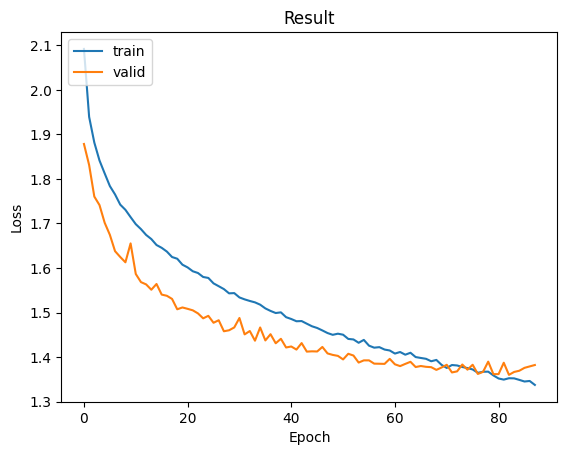

Best model loaded from ./checkpoints\best_model.ckpt


In [ ]:
from Trainer import Trainer
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
trainer = Trainer(
    epochs=100,
    train_loader=train_loader,
    valid_loader=valid_loader,
    model=model,
    optimizer=optimizer,
    early_stopping=5,
    load_best_model=True,
)

trainer.train(show_loss=True)

Eval: 100%|██████████| 157/157 [00:00<00:00, 273.05it/s]


              precision    recall  f1-score   support

    Airplane     0.5847    0.5210    0.5510      1000
        Bird     0.4499    0.3230    0.3760      1000
         Car     0.6270    0.6320    0.6295      1000
         Cat     0.3273    0.3440    0.3354      1000
        Deer     0.3966    0.5100    0.4462      1000
         Dog     0.4720    0.4380    0.4544      1000
        Frog     0.6388    0.5430    0.5870      1000
       Horse     0.6286    0.6550    0.6415      1000
        Ship     0.6219    0.6350    0.6284      1000
       Truck     0.5286    0.6370    0.5778      1000

    accuracy                         0.5238     10000
   macro avg     0.5275    0.5238    0.5227     10000
weighted avg     0.5275    0.5238    0.5227     10000



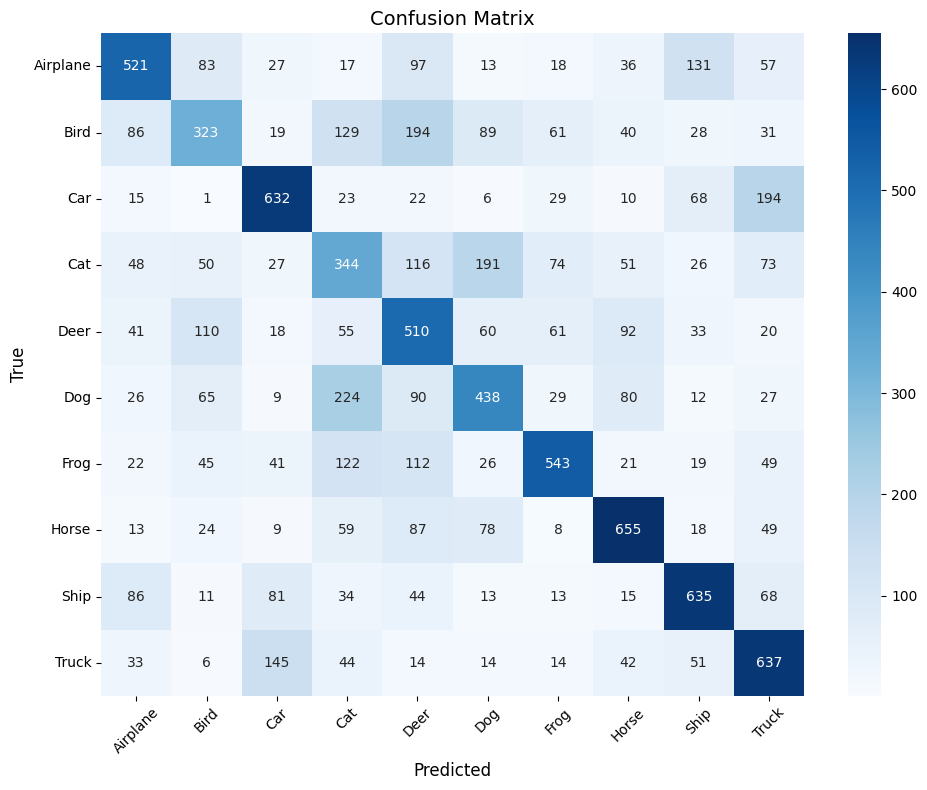

In [7]:
import torch
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_and_report(model, data_loader, label_decoding, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    all_preds = []
    all_labels = []
    eval_pbar = tqdm(data_loader, position=0, leave=True)

    for input_datas in eval_pbar:
        input_datas = {k: v.to(device) for k, v in input_datas.items()}
        preds = model.predict(**input_datas)
        labels = input_datas['y']
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        eval_pbar.set_description(f'Eval')

    decoded_labels = [label_decoding[l] for l in all_labels]
    decoded_preds = [label_decoding[p] for p in all_preds]

    print(classification_report(decoded_labels, decoded_preds, digits=4, zero_division=0))

    cm = confusion_matrix(decoded_labels, decoded_preds, labels=list(label_decoding.values()))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(label_decoding.values()),
                yticklabels=list(label_decoding.values()))
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

evaluate_and_report(model, valid_loader, label_decoding)



Top 5 Predictions:



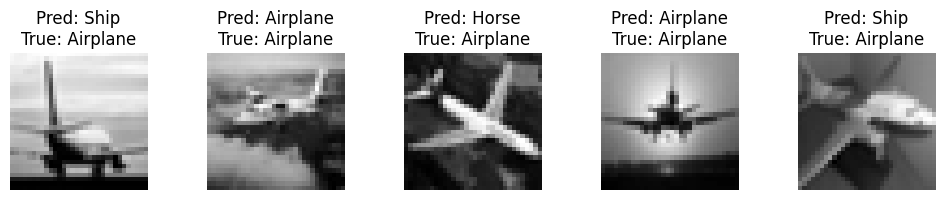

In [8]:
def show_sample_predictions(model, x_valid, y_valid, label_decoding, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x_valid_array = np.array(x_valid)
        x_valid_tensor = torch.from_numpy(x_valid_array).float().to(device)
        y_pred = model.predict(x = x_valid_tensor)

    print(f'\nTop {num_samples} Predictions:\n')
    num_samples = min(num_samples, len(x_valid))
    plt.figure(figsize=(2 * num_samples, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(x_valid[i], cmap='gray')
        plt.title(f'Pred: {label_decoding[y_pred[i]]}\nTrue: {label_decoding[y_valid[i]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_predictions(model, x_valid, y_valid, label_decoding=label_decoding, num_samples=5)